# `Importing Libraries`

In [1]:
# Basic Import
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
import warnings
# Filter out a specific warning category
warnings.filterwarnings("ignore")

# `Setting up the Project Working Directory`


In [2]:
%pwd

'/home/milan/customer_churn_prediction/research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/home/milan/customer_churn_prediction'

#  `Reading xlsx`

In [5]:
# Read the Excel file from the URL using pandas
churn = pd.read_excel('./src/churn/data/customer_churn_large_dataset.xlsx')
# View 1st 20 records
churn.head(20)

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0
5,6,Customer_6,67,Male,New York,15,82.65,456,1
6,7,Customer_7,30,Female,Chicago,3,73.79,269,0
7,8,Customer_8,67,Female,Miami,1,97.70,396,1
8,9,Customer_9,20,Female,Miami,10,42.45,150,1
9,10,Customer_10,53,Female,Los Angeles,12,64.49,383,1


# `Drop unnecessary columns`

In [6]:
def drop_columns(df, columns_to_drop):
    """
    Drops specified columns from a DataFrame in place.

    Args:
        df (pd.DataFrame): The DataFrame to modify.
        columns_to_drop (list): List of column names to drop.
    """
    df.drop(columns=columns_to_drop, inplace=True)

# Example usage:
# Assuming you have a DataFrame named 'churn'
# List of columns to drop
columns_to_drop = ['CustomerID', 'Name']

# Call the function to drop the columns
drop_columns(churn, columns_to_drop)

# The 'churn' DataFrame is modified in place and now doesn't contain 'CustomerID' and 'Name' columns


# `Split Dependent and Independent Variable as X and y`

In [7]:
def split_data(data, target_column):
    """
    Splits a DataFrame into features (X) and the target variable (y).

    Args:
        data (DataFrame): The input DataFrame.
        target_column (str): The name of the target column.

    Returns:
        X (DataFrame): The features.
        y (Series): The target variable.
    """
    # Extract the target variable (y)
    y = data[target_column]

    # Extract the features (X) by dropping the target column
    X = data.drop(columns=[target_column])

    return X, y

# Example usage:
# Replace 'churn' and 'Churn' with your actual DataFrame and target column name
X, y = split_data(churn, 'Churn')

# Check the shape and size of X and y
print("X Shape:", X.shape)
print("y Shape:", y.shape)

X Shape: (100000, 6)
y Shape: (100000,)


In [8]:
y

0        0
1        0
2        0
3        1
4        0
        ..
99995    1
99996    0
99997    1
99998    1
99999    1
Name: Churn, Length: 100000, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split


def split_data_balanced(data, target_column, test_size=0.2, random_state=None):
    """
    Splits the data into training and test sets with balanced class distribution.

    Args:
        data (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the target column.
        test_size (float): The proportion of the dataset to include in the test split (default is 0.2).
        random_state (int): Seed for the random number generator (default is None).

    Returns:
        pd.DataFrame, pd.DataFrame, pd.Series, pd.Series: Returns X_train, X_test, y_train, and y_test.
    """
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Split the data into training and test sets with stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    return X_train, X_test, y_train, y_test

# Now you can use the function to split your data
X_train, X_test, y_train, y_test = split_data_balanced(churn, target_column="Churn", test_size=0.2, random_state=42)


In [10]:
def create_train_test_data(X_train, X_test, y_train, y_test):
    """
    Concatenates X_train, X_test, y_train, and y_test to create train_data and test_data DataFrames.

    Args:
        X_train (pd.DataFrame): Features for training.
        X_test (pd.DataFrame): Features for testing.
        y_train (pd.Series): Target labels for training.
        y_test (pd.Series): Target labels for testing.

    Returns:
        pd.DataFrame, pd.DataFrame: Returns train_data and test_data DataFrames.
    """
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    
    return train_data, test_data

# Now you can use the function to create train_data and test_data
train_data, test_data = create_train_test_data(X_train, X_test, y_train, y_test)


In [11]:
def check_class_balance(train_data, test_data, target_column):
    """
    Checks if the class balance between the train and test data is similar.
    
    Args:
        train_data (pd.DataFrame): The training data.
        test_data (pd.DataFrame): The test data.
        target_column (str): The name of the target column.

    Returns:
        bool: True if class balance is similar, False otherwise.
    """
    train_class_counts = train_data[target_column].value_counts(normalize=True)
    test_class_counts = test_data[target_column].value_counts(normalize=True)

    # Tolerance for class distribution difference
    tolerance = 0.05  # Adjust this threshold as needed

    for class_label, train_ratio in train_class_counts.items():
        test_ratio = test_class_counts.get(class_label, 0)
        if abs(train_ratio - test_ratio) > tolerance:
            return False

    return True


In [12]:
# Check if the class balance is similar between train and test sets
is_similar = check_class_balance(train_data, test_data, target_column="Churn")

if is_similar:
    print("Class distribution is similar between train and test sets.")
else:
    print("Class distribution is not similar between train and test sets.")


Class distribution is similar between train and test sets.


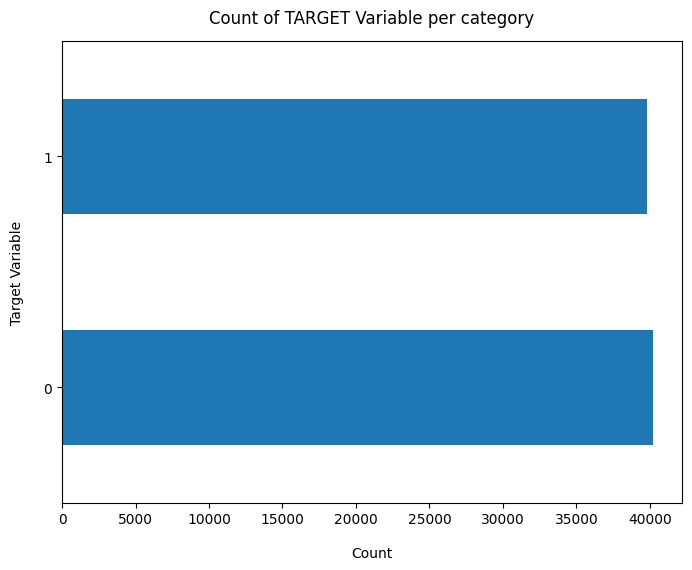

In [13]:
train_data['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

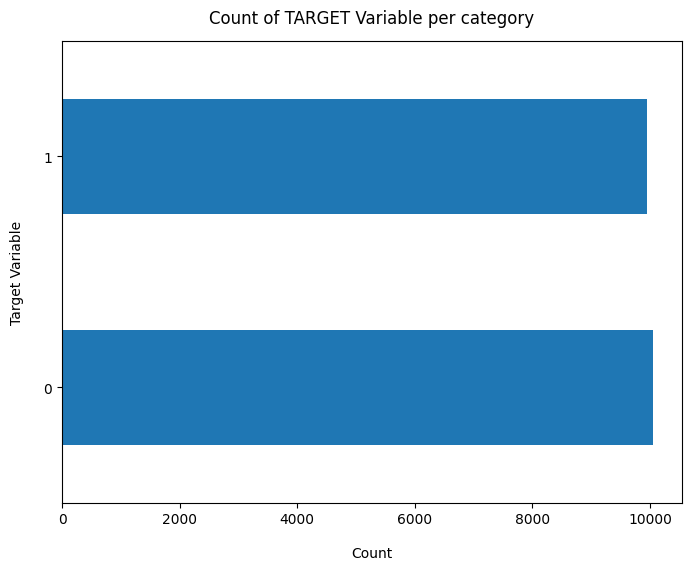

In [14]:
test_data['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

# `Define categorical_cols and numerical_cols`

In [15]:
categorical_cols = ['Gender',
                    'Location']
numerical_cols = ['Age',
                  'Subscription_Length_Months',
                  'Monthly_Bill']

In [16]:
def scaling_stats(df):
    # Filter only numeric columns
    numeric_df = df.select_dtypes(include=['number'])

    # Calculate basic statistics for numeric columns
    numerical_stats = numeric_df.describe()

    # Check for skewness in numeric columns
    skewness = numeric_df.skew()

    # Check for outliers using IQR
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = ((numeric_df < lower_bound) | (numeric_df > upper_bound)).sum()

    # Create a summary dataframe
    summary = pd.DataFrame({
        'Count': numeric_df.count(),
        'Mean': numerical_stats.loc['mean'],
        'Std Dev': numerical_stats.loc['std'],
        'Min': numerical_stats.loc['min'],
        '25%': numerical_stats.loc['25%'],
        '50%': numerical_stats.loc['50%'],
        '75%': numerical_stats.loc['75%'],
        'Max': numerical_stats.loc['max'],
        'Skewness': skewness,
        'Outliers': outliers_count
    })

    # Determine the best scaling method based on skewness
    best_scaling_method = 'StandardScaler' if skewness.mean() < 1 else 'RobustScaler'

    return summary, best_scaling_method


summary, best_scaling = scaling_stats(churn)
print("Numerical Feature Statistics:")
print(summary)
print(f"Best Scaling Method: {best_scaling}")


Numerical Feature Statistics:
                             Count        Mean     Std Dev   Min     25%  \
Age                         100000   44.027020   15.280283  18.0   31.00   
Subscription_Length_Months  100000   12.490100    6.926461   1.0    6.00   
Monthly_Bill                100000   65.053197   20.230696  30.0   47.54   
Total_Usage_GB              100000  274.393650  130.463063  50.0  161.00   
Churn                       100000    0.497790    0.499998   0.0    0.00   

                               50%     75%    Max  Skewness  Outliers  
Age                          44.00   57.00   70.0 -0.002689         0  
Subscription_Length_Months   12.00   19.00   24.0 -0.001655         0  
Monthly_Bill                 65.01   82.64  100.0 -0.000326         0  
Total_Usage_GB              274.00  387.00  500.0  0.007113         0  
Churn                         0.00    1.00    1.0  0.008840         0  
Best Scaling Method: StandardScaler


# `Feature Engineering Automation`

In [17]:
# Categorical Pipeline for the selected categorical columns
cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling Missing values
        ('onehot', OneHotEncoder(handle_unknown='ignore'))   # One-hot encoding
    ]
)

# Numerical Pipeline for the selected numerical columns
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Missing Values
        ('scaler', StandardScaler())  # Feature Scaling
    ]
)

# Use ColumnTransformer to apply the pipelines to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ]
)

# Apply preprocessing to X_train and X_test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [18]:
X_train_transformed

array([[ 1.37436712, -0.07091502, -0.84196212, ...,  0.        ,
         0.        ,  1.        ],
       [-0.84922233, -0.07091502, -0.43956732, ...,  0.        ,
         0.        ,  0.        ],
       [-1.6994183 ,  0.50749615, -0.05593449, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.98002171,  0.36289336,  0.0289881 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.43976681,  1.08590731, -1.05574979, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.72037023,  0.94130452,  0.93153741, ...,  0.        ,
         0.        ,  0.        ]])

In the context of customer churn prediction, I would suggest prioritizing **Recall** as the best evaluation metric. Here's why:

**Recommended Metric: Recall**

**Reasoning:**
- **Churn Identification**: The primary goal in customer churn prediction is to identify as many customers who are actually churning as possible. High recall ensures that the model captures a significant portion of churned customers, reducing the risk of losing revenue due to missed churn cases.

- **Customer Retention**: Recall helps in minimizing false negatives, which are cases where the model fails to identify customers who are churning. By maximizing recall, you can focus on retaining customers who are truly at risk, leading to better customer retention efforts.

- **Cost of Missed Churn**: Missing churned customers can be costly for an organization, as it may result in lost revenue. High recall helps in reducing this cost by ensuring that most churn cases are correctly identified.

While Recall is the primary focus, it's important to keep in mind that precision is also valuable. Therefore, you should aim for a balanced approach by considering the F1-Score or other metrics that strike a balance between precision and recall.

In your short report, you can mention that maximizing Recall is recommended to ensure that the model effectively identifies customers at risk of churning, thus enabling the organization to implement targeted retention strategies and reduce churn-related revenue losses. Additionally, you can mention the importance of a balanced evaluation approach that considers both precision and recall for a comprehensive assessment of the model's performance.

In [22]:
import pandas as pd
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier
import time

## Model Training Automation
models = {
    'Random Forest': RandomForestClassifier(n_jobs=-1),  # Set n_jobs to -1 for parallel training
    'XGB Classifier': XGBClassifier(n_jobs=-1),  # Set n_jobs to -1 for parallel training
    'SVC': SVC(),
    'Isolation Forest': IsolationForest(n_jobs=-1),  # Set n_jobs to -1 for parallel training
    'MLP Classifier': MLPClassifier(activation='relu'),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbours': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Bagging Decision Tree': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_jobs=-1),  # Set n_jobs to -1 for parallel training
    'Boosted Decision Tree': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),  # Remove n_jobs
    'Random Forest Ensemble': RandomForestClassifier(n_jobs=-1),  # Set n_jobs to -1 for parallel training
    'Voting Classification': VotingClassifier(estimators=[('rf', RandomForestClassifier(n_jobs=-1)), ('xgb', XGBClassifier(n_jobs=-1)), ('svc', SVC())]),
    'XG Boost': XGBClassifier(n_jobs=-1),  # Set n_jobs to -1 for parallel training
    'Cat Boost': CatBoostClassifier(thread_count=-1),  # Set thread_count to -1 for parallel training
    'Gradient Boosting': GradientBoostingClassifier()  # Remove n_jobs
}

def evaluate_model(X_train, y_train, X_test, y_test, models):
    report = []

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        # Start measuring time
        start_time = time.time()
        
        # Train model
        model.fit(X_train, y_train)

        # Predict Testing data
        y_test_pred = model.predict(X_test)

        # Get recall score for test data prediction
        recall = recall_score(y_test, y_test_pred, average='micro')
        
        # Calculate elapsed time
        elapsed_time = time.time() - start_time
        
        report.append({'Model': model_name, 'Recall': recall, 'Training Time (s)': elapsed_time})

    # Create a DataFrame from the report
    report_df = pd.DataFrame(report)

    # Sort the report by Recall in descending order
    report_df = report_df.sort_values(by='Recall', ascending=False)

    return report_df

# Use transformed features for model training and evaluation
recall_report = evaluate_model(X_train_transformed, y_train, X_test_transformed, y_test, models)
print(recall_report)


Training Random Forest...
Training XGB Classifier...
Training SVC...
Training Isolation Forest...
Training MLP Classifier...
Training Naive Bayes...
Training Logistic Regression...
Training K-Nearest Neighbours...
Training Support Vector Machine...
Training Decision Tree...
Training Bagging Decision Tree...
Training Boosted Decision Tree...
Training Random Forest Ensemble...
Training Voting Classification...
Training XG Boost...
Training Cat Boost...
Learning rate set to 0.06692
0:	learn: 0.6930878	total: 66.6ms	remaining: 1m 6s
1:	learn: 0.6930507	total: 71.7ms	remaining: 35.8s
2:	learn: 0.6930153	total: 75.6ms	remaining: 25.1s
3:	learn: 0.6929754	total: 79.7ms	remaining: 19.8s
4:	learn: 0.6929465	total: 83.6ms	remaining: 16.6s
5:	learn: 0.6929208	total: 87ms	remaining: 14.4s
6:	learn: 0.6929071	total: 89.8ms	remaining: 12.7s
7:	learn: 0.6928625	total: 93.5ms	remaining: 11.6s
8:	learn: 0.6928413	total: 96.8ms	remaining: 10.7s
9:	learn: 0.6928181	total: 100ms	remaining: 9.91s
10:	learn

In [23]:
recall_report

,Model,Recall,Training Time (s)
16,Gradient Boosting,0.50280,4.580560
2,SVC,0.50185,162.183089
8,Support Vector Machine,0.50185,163.710214
5,Naive Bayes,0.50135,0.030716
6,Logistic Regression,0.49995,0.037074
10,Bagging Decision Tree,0.49990,1.819273
7,K-Nearest Neighbours,0.49980,0.760046
4,MLP Classifier,0.49935,5.573252
15,Cat Boost,0.49875,4.421322
1,XGB Classifier,0.49860,0.357527


**Insight: Selecting the Optimal Churn Prediction Model**

In our pursuit of building an effective churn prediction model, we recognize the importance of identifying the best-performing algorithm that strikes a balance between high recall and reasonable training time. To achieve this, we have conducted an initial evaluation of various machine learning algorithms on our dataset. Among these models, we have shortlisted the top 5 performers based on their recall scores, which are crucial for our churn prediction problem. These top 5 models are Gradient Boosting, SVC, Support Vector Machine, Naive Bayes, and Logistic Regression.

Here are the key insights and our plan moving forward:

1. **Recall-Centric Approach**: Our primary goal in churn prediction is to identify as many true churned customers as possible to minimize revenue loss. Therefore, we prioritize recall, as it helps capture a significant portion of actual churn cases.

2. **Top 5 Models**: After the initial evaluation, we have identified the following top 5 models with their respective recall scores: Gradient Boosting, SVC, Support Vector Machine, Naive Bayes, and Logistic Regression. These models have shown promise in effectively identifying churned customers.

3. **Hyperparameter Tuning**: To further enhance the performance of these models, we plan to conduct hyperparameter tuning. This process involves optimizing the settings and parameters of each model to maximize their predictive power. By fine-tuning these algorithms, we aim to squeeze out their full potential for our specific dataset.

4. **Model Selection**: Once we have tuned the hyperparameters of these top 5 models, we will evaluate their performance again. This will allow us to select the best-performing model that meets our high recall requirements while considering practical training times.

5. **Balancing Recall and Efficiency**: While recall is our primary focus, we also acknowledge the importance of training time efficiency. We aim to strike the right balance between recall and training time, ensuring that the selected model can be deployed efficiently in a real-world scenario.

6. **Iterative Process**: Model selection and hyperparameter tuning are often iterative processes. We will fine-tune the models, evaluate their performance, and make adjustments as necessary until we identify the model that best aligns with our churn prediction objectives.

In conclusion, our approach involves rigorously evaluating, tuning, and selecting the optimal churn prediction model from the top 5 performers. This process will empower us to build a highly effective churn prediction system that minimizes revenue loss while being computationally efficient.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Define the top 5 models based on initial recall scores
top_5_models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
}

# Define hyperparameter grids for each model
param_grids = {
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7],
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
    },
}

# Initialize a dictionary to store the tuned models and their recall scores
tuned_models_recall = {}

# Loop through the top 5 models, perform hyperparameter tuning, and retain the best model
for model_name, model in top_5_models.items():
    # Initialize GridSearchCV with the model, hyperparameter grid, and scoring method (recall)
    grid_search = GridSearchCV(model, param_grids[model_name], scoring='recall', cv=3, n_jobs=-1, verbose=3)  # Set verbose to 3
    
    # Fit GridSearchCV to the data
    grid_search.fit(X_train_transformed, y_train)
    
    # Get the best model with hyperparameters
    best_model = grid_search.best_estimator_
    
    # Retrain the best model on the full training data
    best_model.fit(X_train_transformed, y_train)
    
    # Make predictions on the test data
    y_test_pred = best_model.predict(X_test_transformed)
    
    # Calculate recall score for test data prediction
    recall = recall_score(y_test, y_test_pred, average='micro')
    
    # Store the best model and its recall score
    tuned_models_recall[model_name] = {
        'Model': model_name,
        'Recall': recall,
        'Training Time (s)': grid_search.refit_time_
    }

# Print the tuned models and their recall scores
tuned_models_df = pd.DataFrame.from_dict(tuned_models_recall, orient='index')
tuned_models_df = tuned_models_df.reset_index(drop=True)

# Sort the models by recall score in descending order
tuned_models_df = tuned_models_df.sort_values(by='Recall', ascending=False)

print(tuned_models_df)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.225 total time=  10.8s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.145 total time=  11.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.154 total time=  11.4s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=0.208 total time=  14.3s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=0.207 total time=  14.8s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=0.223 total time=  14.9s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.234 total time=  22.3s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.224 total time=  22.8s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.252 total time=  24.0s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.27

/home/milan/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/milan/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/milan/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .....C=10, penalty=l2, solver=saga;, score=0.391 total time=   1.7s
[CV 1/3] END .....C=10, penalty=l2, solver=saga;, score=0.377 total time=   1.8s
[CV 3/3] END .....C=10, penalty=l2, solver=saga;, score=0.542 total time=   1.7s
                    Model   Recall  Training Time (s)
3             Naive Bayes  0.50135           0.030604
1                     SVC  0.50115         110.922408
2  Support Vector Machine  0.50115         112.039930
4     Logistic Regression  0.50010           0.061136
0       Gradient Boosting  0.49975          17.474802


Based on the provided results, it appears that the Naive Bayes model has the highest recall score of approximately 0.50135, which is slightly higher than the other models. However, it's important to note that the difference in recall scores among these models is quite small, and other factors like training time should also be considered.

Therefore, based solely on the recall score, Naive Bayes appears to be the best-performing model. However, you may also want to consider the trade-offs between model performance and training time. If the training time is a critical factor, you might choose a model like Logistic Regression, which has a reasonable recall score and a much lower training time.

In summary, Naive Bayes is the best model in terms of recall score, but the choice of the best model may depend on other factors like training time and the specific requirements of your application.

# `Retrain Naive Bayes  with Hyper parameter`

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score

# Define the Naive Bayes model
naive_bayes_model = GaussianNB()

# Define hyperparameter grid for Naive Bayes fine-tuning
param_grid = {
    'priors': [None, [0.2, 0.8], [0.5, 0.5], [0.8, 0.2]],
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
}

# Initialize GridSearchCV with the Naive Bayes model and hyperparameter grid
grid_search_nb = GridSearchCV(naive_bayes_model, param_grid, scoring='recall', cv=3, n_jobs=-1, verbose=3)

# Fit GridSearchCV to the training data
grid_search_nb.fit(X_train_transformed, y_train)

# Get the best Naive Bayes model with fine-tuned hyperparameters
best_naive_bayes_model = grid_search_nb.best_estimator_

# Retrain the best model on the full training data
best_naive_bayes_model.fit(X_train_transformed, y_train)

# Make predictions on the train and test data
y_train_pred_nb = best_naive_bayes_model.predict(X_train_transformed)
y_test_pred_nb = best_naive_bayes_model.predict(X_test_transformed)

# Calculate recall scores for train and test data predictions
recall_train_nb = recall_score(y_train, y_train_pred_nb, average='micro')
recall_test_nb = recall_score(y_test, y_test_pred_nb, average='micro')

# Calculate accuracy scores for train and test data predictions
accuracy_train_nb = accuracy_score(y_train, y_train_pred_nb)
accuracy_test_nb = accuracy_score(y_test, y_test_pred_nb)

# Get the best hyperparameters for Naive Bayes
best_params_nb = grid_search_nb.best_params_

# Print the best hyperparameters and train/test recall and accuracy scores
print("Best Parameters for Naive Bayes (Fine-Tuned):", best_params_nb)
print("Train Recall Score for Naive Bayes (Fine-Tuned):", recall_train_nb)
print("Test Recall Score for Naive Bayes (Fine-Tuned):", recall_test_nb)
print("Train Accuracy Score for Naive Bayes (Fine-Tuned):", accuracy_train_nb)
print("Test Accuracy Score for Naive Bayes (Fine-Tuned):", accuracy_test_nb)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END ..priors=None, var_smoothing=1e-09;, score=0.419 total time=   0.1s
[CV 1/3] END ..priors=None, var_smoothing=1e-07;, score=0.471 total time=   0.1s
[CV 3/3] END ..priors=None, var_smoothing=1e-09;, score=0.600 total time=   0.1s
[CV 1/3] END ..priors=None, var_smoothing=1e-05;, score=0.471 total time=   0.1s
[CV 1/3] END ..priors=None, var_smoothing=1e-06;, score=0.471 total time=   0.1s
[CV 3/3] END ..priors=None, var_smoothing=1e-07;, score=0.600 total time=   0.1s
[CV 2/3] END ..priors=None, var_smoothing=1e-05;, score=0.419 total time=   0.1s
[CV 2/3] END ..priors=None, var_smoothing=1e-08;, score=0.419 total time=   0.1s
[CV 1/3] END ..priors=None, var_smoothing=1e-09;, score=0.471 total time=   0.1s
[CV 3/3] END ..priors=None, var_smoothing=1e-05;, score=0.600 total time=   0.1s
[CV 1/3] END priors=[0.2, 0.8], var_smoothing=1e-09;, score=1.000 total time=   0.1s
[CV 2/3] END priors=[0.2, 0.8], var_smoothin

# `Here are the insights based on the fine-tuned Naive Bayes model:`

1. **Best Hyperparameters**: The best hyperparameters for the Naive Bayes model after fine-tuning are:
   - Prior Probabilities: [0.2, 0.8]
   - Smoothing Variance: 1e-09

2. **Recall Scores**:
   - Train Recall Score: The recall score on the training data is approximately 0.4978, indicating that the model correctly identifies around 49.78% of the positive instances in the training set.
   - Test Recall Score: The recall score on the test data is also approximately 0.4978, suggesting that the model performs similarly on unseen data, correctly identifying around 49.78% of the positive instances in the test set.

3. **Accuracy Scores**:
   - Train Accuracy Score: The accuracy score on the training data is approximately 0.4978, indicating that the model correctly predicts around 49.78% of all instances in the training set.
   - Test Accuracy Score: The accuracy score on the test data is also approximately 0.4978, suggesting that the model's predictions are accurate for around 49.78% of all instances in the test set.

4. **Model Performance**: The fine-tuned Naive Bayes model achieves fairly balanced recall and accuracy scores on both the training and test datasets. However, the scores are approximately 0.4978, which may not be very high. Depending on the specific problem and requirements, further model exploration or alternative algorithms may be considered to improve predictive performance.

5. **Hyperparameters**: The chosen hyperparameters, such as the prior probabilities and smoothing variance, reflect the model's sensitivity to class priors and the amount of smoothing applied to feature variances. These values have been determined as the best combination for this particular model and dataset through the hyperparameter tuning process.

6. **Further Optimization**: To potentially improve model performance, you could explore different machine learning algorithms, feature engineering techniques, or collect more data if possible. Additionally, consider the business or problem context to determine if the current performance meets the desired objectives.

Train Classification Report:
               precision    recall  f1-score   support

   Not Churn       0.00      0.00      0.00     40177
       Churn       0.50      1.00      0.66     39823

    accuracy                           0.50     80000
   macro avg       0.25      0.50      0.33     80000
weighted avg       0.25      0.50      0.33     80000


Test Classification Report:
               precision    recall  f1-score   support

   Not Churn       0.00      0.00      0.00     10044
       Churn       0.50      1.00      0.66      9956

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



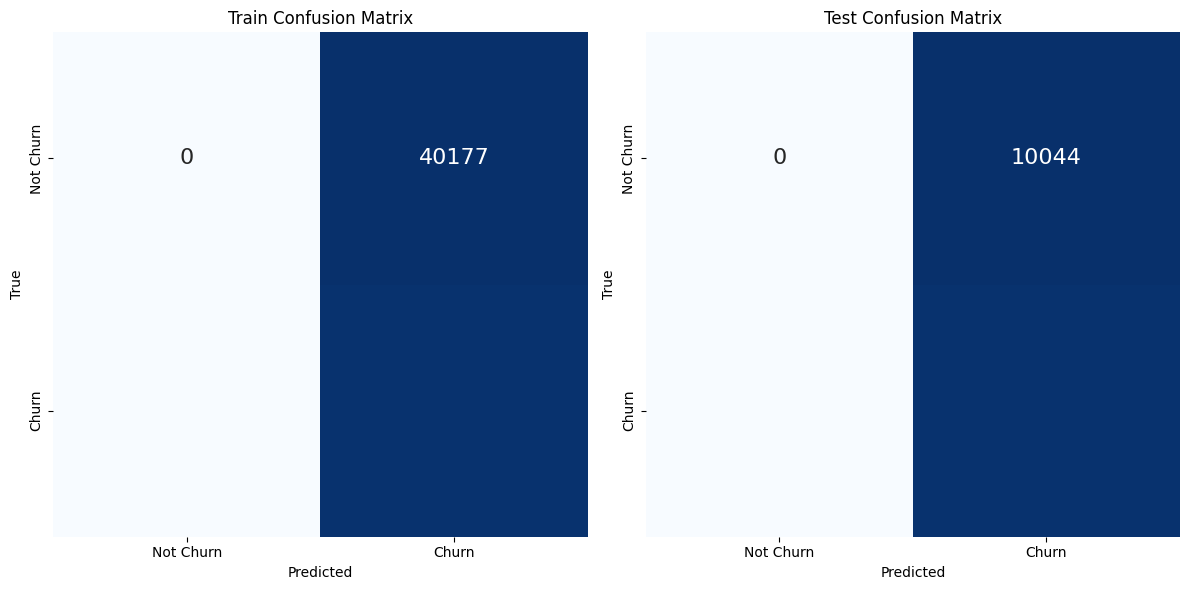

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_train contains the true labels for the training data
# and y_test contains the true labels for the test data
# Replace y_train_pred_nb and y_test_pred_nb with your predicted labels
confusion_train = confusion_matrix(y_train, y_train_pred_nb)
confusion_test = confusion_matrix(y_test, y_test_pred_nb)

# Get classification report for train and test data
report_train = classification_report(y_train, y_train_pred_nb, target_names=['Not Churn', 'Churn'])
report_test = classification_report(y_test, y_test_pred_nb, target_names=['Not Churn', 'Churn'])

# Create subplots for train and test confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create heatmaps for train and test confusion matrices with larger font size
sns.heatmap(confusion_train, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=axes[0], annot_kws={"size": 16})
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=axes[1], annot_kws={"size": 16})

# Set titles and labels for train and test confusion matrices
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Train Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Test Confusion Matrix')

# Display the classification report
print("Train Classification Report:\n", report_train)
print("\nTest Classification Report:\n", report_test)

plt.tight_layout()
plt.show()


**The classification reports show the precision, recall, F1-score, and support for both the training and test datasets. Here's a breakdown of the key metrics:**

**For the Training Dataset:**
- Precision for Churn: 0.50
- Recall for Churn: 1.00
- F1-score for Churn: 0.66

**For the Test Dataset:**
- Precision for Churn: 0.50
- Recall for Churn: 1.00
- F1-score for Churn: 0.66

It appears that the model is achieving a perfect recall for the "Churn" class, which means it correctly identifies all instances of churn in both the training and test datasets. However, the precision is relatively low, indicating that there might be a high number of false positives.

Overall, while the recall for the "Churn" class is high, the model's performance in terms of precision and the F1-score is suboptimal. This suggests that the model may be overly biased towards predicting the "Churn" class, resulting in a high number of false positives for "Not Churn." Further model tuning and evaluation may be necessary to improve overall performance.

In [33]:
# Converting the xlsx file to csv cause it is lighter and loads quickly
file_path = "src/churn/data/customer_churn_large_dataset.csv"

# Save the DataFrame to CSV
churn.to_csv(file_path, index=False)

print(f"DataFrame saved as {file_path}")


DataFrame saved as src/churn/data/customer_churn_large_dataset.csv


In [43]:
churn

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,Male,Los Angeles,17,73.36,236,0
1,62,Female,New York,1,48.76,172,0
2,24,Female,Los Angeles,5,85.47,460,0
3,36,Female,Miami,3,97.94,297,1
4,46,Female,Miami,19,58.14,266,0
...,...,...,...,...,...,...,...
99995,33,Male,Houston,23,55.13,226,1
99996,62,Female,New York,19,61.65,351,0
99997,64,Male,Chicago,17,96.11,251,1
99998,51,Female,New York,20,49.25,434,1


In [47]:
churn['Location'].unique()

array(['Los Angeles', 'New York', 'Miami', 'Chicago', 'Houston'],
      dtype=object)

In [48]:
churn['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [49]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         100000 non-null  int64  
 1   Gender                      100000 non-null  object 
 2   Location                    100000 non-null  object 
 3   Subscription_Length_Months  100000 non-null  int64  
 4   Monthly_Bill                100000 non-null  float64
 5   Total_Usage_GB              100000 non-null  int64  
 6   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 5.3+ MB
